In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from sklearn.decomposition import TruncatedSVD #importing just to do truncatedSVD for me, I didn't have the time(and energy :) ) to implement by myself.

In [2]:
IMAGE_PATH = './Medical_MNIST'
print(os.path.abspath(IMAGE_PATH))

C:\Users\Acer\Desktop\sem5\ell409\Assignment_1\Medical_MNIST


In [3]:
#data_loader
from tqdm import tqdm
def data_loader():
    X = []
    Y = []
    i = 0
    for folder in os.listdir(os.path.abspath(IMAGE_PATH)):
        IMAGE_DIR = os.path.join(IMAGE_PATH, folder)
        print("Reading" + IMAGE_DIR)
        for file in tqdm(os.listdir(IMAGE_DIR)):
            X.append((np.asarray(Image.open(os.path.join(IMAGE_DIR, file)))).reshape(-1))
            Y.append(i)
        
        i += 1
    print('Completed Loading Data. Saving as np file so that can directy load array nexttime')
    np.savez('q3data.npz', X = np.array(X), Y = np.array(Y))
    return np.array(X), np.array(Y)

if 'q3data.npz' in os.listdir('./'):
    zfile = np.load('q3data.npz')
    X_ = zfile['X']
    Y_ = zfile['Y']
else:
    X_, Y_ = data_loader()

split = 0.7 #using 70:30 split, random each time
train_samples = np.random.choice(X_.shape[0], int(split*X_.shape[0]))
#test_samples = np.array([i for i in range(X_.shape[0]) if i not in list(train_samples)])

X = X_[[train_samples]]
Y = Y_[[train_samples]]

C:\Users\Acer\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
C:\Users\Acer\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [4]:
print(f'X.shape = {X.shape}') #oof!

X.shape = (41267, 4096)


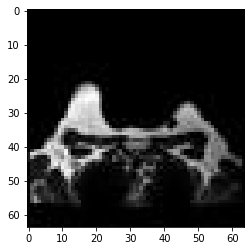

In [5]:
#Visualizing the images.
plt.imshow(X[0].reshape(64, -1), cmap='gray')

In [6]:
#Lets try to do PCA on the input images??
h, w = 64, 64
'''
def pca(X, n_pc):
    n_samples, n_features = X.shape
    mean = np.mean(X, axis=0)
    centered_data = X-mean
    U, S, V = np.linalg.svd(centered_data)
    components = V[:n_pc]
    projected = U[:,:n_pc]*S[:n_pc]
    
    return projected, components, mean, centered_data
    #credits to https://towardsdatascience.com/eigenfaces-recovering-humans-from-ghosts-17606c328184 for helping me write PCA
    #and saving me a few hours.
'''
"""It helps visualising the portraits from the dataset."""
def plot_portraits(images, titles, h, w, n_row, n_col):
    plt.figure(figsize=(2.2 * n_col, 2.2 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.20)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i])
        plt.xticks(())
        plt.yticks(())
'''
n_components = 50
P, C, M, X_centered=pca(X[:1000], n_pc=n_components)
#P->lower dimensional version of X, C-> Eigen vectors with largest eigen values, M->mean image (used in reconstruction)
eigenscans = C.reshape((n_components, h, w))
eigenscan_titles = ["eigenscan %d" % i for i in range(eigenscans.shape[0])]
plot_portraits(eigenscans, eigenscan_titles, h, w, 4, 4) 
'''

'\nn_components = 50\nP, C, M, X_centered=pca(X[:1000], n_pc=n_components)\n#P->lower dimensional version of X, C-> Eigen vectors with largest eigen values, M->mean image (used in reconstruction)\neigenscans = C.reshape((n_components, h, w))\neigenscan_titles = ["eigenscan %d" % i for i in range(eigenscans.shape[0])]\nplot_portraits(eigenscans, eigenscan_titles, h, w, 4, 4) \n'

In [7]:
def fastpca(X, n_pc):
    n_samples, n_features = X.shape
    mean = np.mean(X, axis=0)
    centered_data = X-mean
    svd = TruncatedSVD(n_components=n_pc, n_iter=7, random_state=42)
    svd.fit(X)
    #U, S, V = np.linalg.svd(centered_data)
    components = svd.components_
    #projected = U[:,:n_pc]*S[:n_pc]
    projected = svd.transform(X)
    return projected, components, mean, centered_data

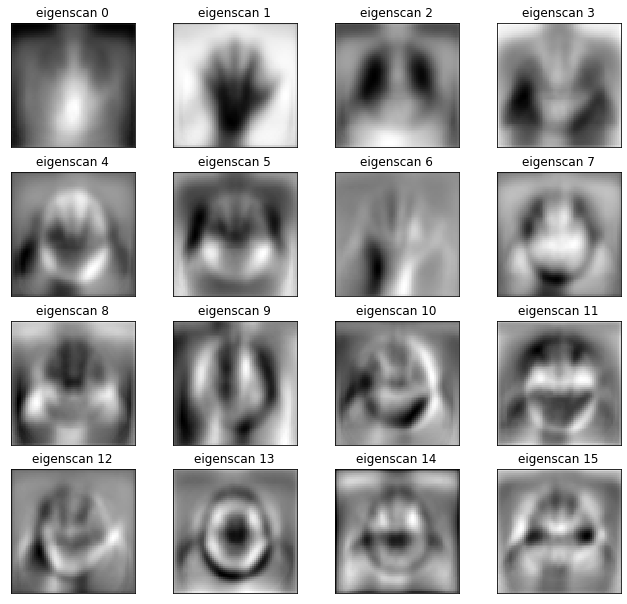

In [8]:
n_components = 200
X_red, C, M, X_centered=fastpca(X, n_pc=n_components)
#X_red->lower dimensional version of X, C-> Eigen vectors with largest eigen values, M->mean image (used in reconstruction)
eigenscans = C.reshape((n_components, h, w))
eigenscan_titles = ["eigenscan %d" % i for i in range(eigenscans.shape[0])]
plot_portraits(eigenscans, eigenscan_titles, h, w, 4, 4) 

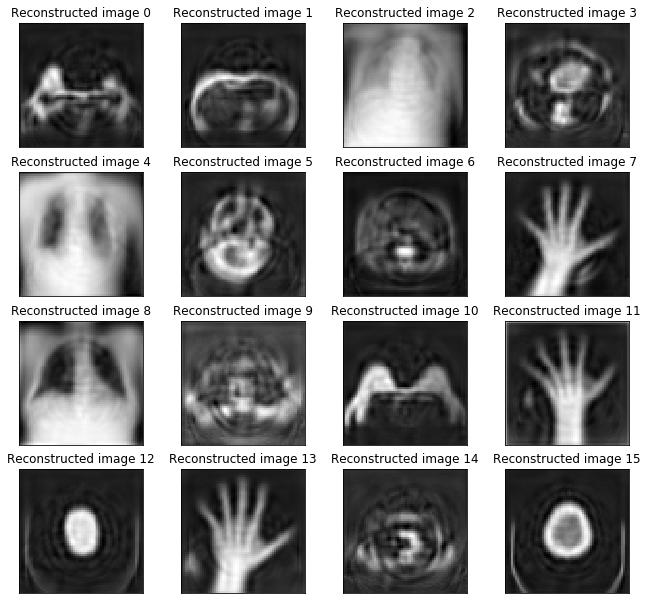

In [9]:
def reconstruction(Y, C, M, h, w, image_index):
    n_samples, n_features = Y.shape
    weights = np.dot(Y, C.T)
    centered_vector=np.dot(weights[image_index, :], C)
    recovered_image=(M+centered_vector).reshape(h, w)
    return recovered_image

recovered_images=[reconstruction(X_centered, C, M, h, w, i) for i in range(20)]
plot_portraits(recovered_images, [f"Reconstructed image {i}" for i in range(len(recovered_images))], h, w, n_row=4, n_col=4)

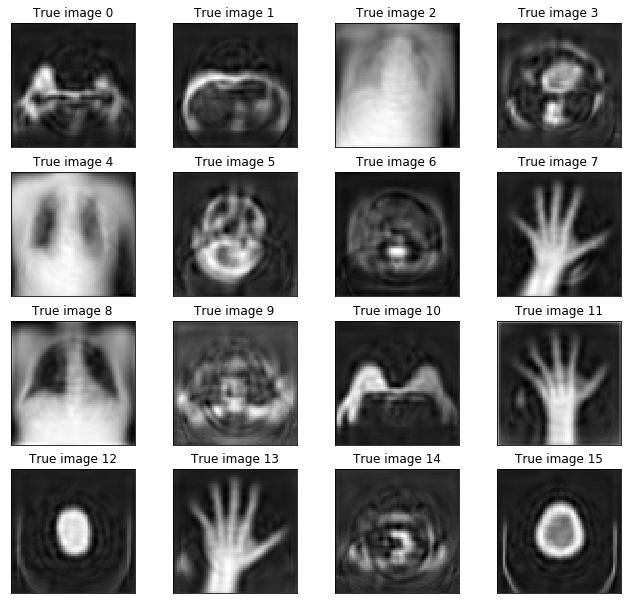

In [10]:
true_images = [X[i].reshape(h, w) for i in range(20)]
plot_portraits(recovered_images, [f"True image {i}" for i in range(len(recovered_images))], h, w, n_row=4, n_col=4)

In [63]:
#looks good to me. Lets try to build a simple bayes classifier.
n_classes = 6
#we assume that the data is zero mean anyways(we centre the data anyways.)
#Assuming equal prior
P = np.ones(n_classes, dtype=np.float64)/n_classes
S = np.zeros((6, n_components, n_components) )
U = np.zeros((6, n_components))
for i in range(len(P)):
    S[i] = np.cov(X_red[[Y==i]], rowvar=False)
    U[i] = np.mean(X_red[[Y==i]], axis=0)        
def bayes(x, P):
    k = 0
    A = np.eye(n_components)*1e-3
    maxval = np.log(P[0]) - 0.5*np.log(np.linalg.det(S[0] @ A)) - 0.5*(x-U[0])@np.linalg.inv(S[0])@(x-U[0]).T
    for i in range(1, len(P)):
        testval = np.log(P[i]) - 0.5*np.log(np.linalg.det(S[i] @ A)) - 0.5*(x-U[i])@np.linalg.inv(S[i])@(x-U[i]).T
        if testval > maxval:
            k = i
            maxval = testval
    return k
            

C:\Users\Acer\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if __name__ == '__main__':
C:\Users\Acer\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # Remove the CWD from sys.path while we load stuff.


In [65]:
#evaluating our baye classifier
C = np.zeros((n_classes, n_classes))
for i in range(len(X_red[:1000])):
    x = X_red[i]
    y = bayes(x, P)
    C[y, Y[i]] += 1

print(C)

[[182.   0.   0.   0.   0.   0.]
 [  0. 147.   0.   0.   0.   0.]
 [  0.   0. 161.   0.   0.   0.]
 [  0.   0.   0. 164.   0.   0.]
 [  0.   0.   0.   0. 169.   0.]
 [  0.   0.   0.   0.   0. 177.]]


In [20]:
X_red[0]

array([ 1764.87600448,  -311.70649965, -1301.73923342, -1381.3477004 ,
       -1046.00882091,   109.72136948,    34.21108578,    -2.81218624,
         531.87884529,   111.98048724,  -425.70052005,  -136.69525466,
         -91.74660228,  -155.28807725,  -155.85352126,  -258.16485208,
        -253.30513632,   210.32453065,  -277.35985687,   341.16332619,
        -164.14267434,  -224.84823342,  -272.0559234 ,  -420.95885242,
         235.6586013 ,   321.52026808,   -67.29784937,   197.51904019,
        -171.74628492,   -35.47680606,   355.76754001,   -40.81613096,
         -84.09243949,    72.86563031,   287.74364693,   217.03059047,
         146.94534215,   -76.19067159,  -251.1379982 ,     7.26747793,
         169.30407419,   401.09508577,   -70.12426024,   150.77699076,
          90.335288  ,     8.05499423,  -145.89715438,  -173.66532426,
        -165.73824266,  -128.26713677,   418.12216044,   127.51952714,
         188.84616069,  -199.30940252,   -58.30237481,  -156.33600854,
      

In [23]:
S.shape

(6, 200, 200)

In [24]:
P

array([0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667])

In [35]:
np.linalg.det(S[0])

inf

In [38]:
S_inv = np.linalg.inv(S[0])
X_red[0] @ S_inv @ X_red[0].T

8712.387532809771

In [39]:
S[0]

array([[ 1.18972268e+05, -2.96418148e+04, -4.58639343e+04, ...,
         1.33758664e+03,  1.91083947e+03, -3.38802020e+02],
       [-2.96418148e+04,  3.08747565e+04,  1.06416429e+04, ...,
         5.92710012e+02, -4.06634661e+02, -1.33206288e+02],
       [-4.58639343e+04,  1.06416429e+04,  6.18001345e+04, ...,
        -8.25243444e+02, -7.00681543e+02,  3.14335608e+02],
       ...,
       [ 1.33758664e+03,  5.92710012e+02, -8.25243444e+02, ...,
         1.60926391e+03, -1.98358927e+02,  1.06842739e+02],
       [ 1.91083947e+03, -4.06634661e+02, -7.00681543e+02, ...,
        -1.98358927e+02,  1.91611253e+03, -9.46243640e+01],
       [-3.38802020e+02, -1.33206288e+02,  3.14335608e+02, ...,
         1.06842739e+02, -9.46243640e+01,  1.75821194e+03]])

In [59]:
A = np.eye(n_components)*1e-3

In [60]:
np.linalg.det(S[0] @ A)

702.6000115185486

In [48]:
np.linalg.det(S[0])

inf